
# Support Vector Machines

 solve the optimization problems by CVXOPT module

### Quadratic Programming (QP)

The standard form of a QP can be formulated as 
$$
\begin{align}
\min_x\quad &\frac12 x^TPx + q^Tx\\
\text{subject to }\quad & Gx \preceq h\\
& Ax = b
\end{align}
$$
where $\preceq$ is an element-wise $\leq$.
CVXOPT solver finds an optimal solution $x^*$, given a set of matrices $P, q, G, h, A, b$.


Design appropriate matrices to solve the following problem.
$$
\begin{align}
\min_x\quad &f(x)=x_1^2 + 4x_2^2-8x_1-16x_2\\
\text{subject to }\quad & x_1+x_2\leq 5\\
& x_1 \leq 3\\
& x_2 \geq 0
\end{align}
$$

You might need to run this command on the Anaconda terminal: 
#### pip install cvxopt

In [ ]:
from cvxopt import matrix, solvers
# Turns off the printing of CVXOPT solution for the rest of the notebook
solvers.options['show_progress'] = False

P = 2 * matrix([[1., 0.], [0., 4.]])
#------------------------------------------------------------------------------------------
# Define q, G, h
# Hint: the x vector is 2x1

q = matrix([[-8., -16.]])
G = matrix([[1., 1., 0.], [1., 0., -1.]] )
h = matrix([[5., 3., 0.]])
#------------------------------------------------------------------------------------------

sol = solvers.qp(P, q, G, h)
x1, x2 = sol['x']
print('Optimal x: ({:.8f}, {:.8f})'.format(x1, x2))

Optimal x: (2.99999993, 1.99927914)


Let's visualize the solution

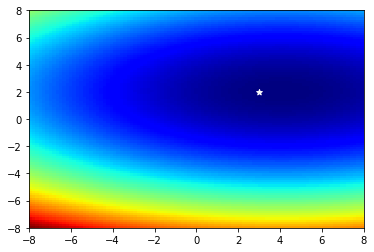

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

X1, X2 = np.meshgrid(np.linspace(-8, 8, 100), np.linspace(-8, 8, 100))
F = X1**2 + 4*X2**2 - 8*X1 - 16 * X2

plt.pcolor(X1, X2, F, cmap='jet')
plt.scatter([x1], [x2], marker='*', color='white')
plt.show()

### Linear SVM

As a linear model, linear SVM produces classification scores for a given sample $x$ as
$$
 \hat y(x) = w^T\phi(x) + b
$$
where $w\in\mathbb{R}^d$, $b\in\mathbb{R}$ are model weights and bias, respectively, and $\phi$ is a fixed feature-space transformation. Final label prediction is done by taking the sign of $\hat y(x)$.

Given a set of training samples $x_n\in\mathbb{R}^d$, $n\in 1,\ldots, N$, with the corresponding labels $y_i\in\{-1, 1\}$ linear SVM is fit (*i.e.* parameters $w$ and $b$ are chosen) by solving the following constrained optimization task:
$$
\begin{align}
    \min_{w, \xi, b}\quad & \frac12||w||^2 + C\sum_{n=1}^N \xi_n\\
    \text{subject to }\quad & y_n\hat y(x_n) \geq 1 - \xi_n, & n=1,\ldots, N\\
    & \xi_n \geq 0, & n=1,\ldots, N
\end{align}
$$

In [ ]:
np.bmat([[np.identity(3), np.zeros((3, 1))],
         [np.zeros((2, 3)), -np.ones((2, 1))]])

matrix([[ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., -1.],
        [ 0.,  0.,  0., -1.]])

In [ ]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, Y):
        """Fit Linear SVM using training dataset (X, Y).
        
        :param X: data samples of shape (N, d).
        :param Y: data target labels of size (N). Each label is either 1 or -1.
        """
        # Apply transformation (phi) to X
        if self.transform is not None:
            X = self.transform(X)
        d = len(X[0])
        N = len(X)
        
        
        #------------------------------------------------------------------------------------------
        # Construct appropriate matrices here to solve the optimization problem described above.
        # We want optimal solution for vector (w, xi, b). 
        P = matrix(np.bmat([[np.identity(d), np.zeros((d, N+1))],
                            [np.zeros((N+1, d)), np.zeros((N+1,N+1 ))]]))
        q =matrix(np.bmat ([np.zeros(d),
                            self.C*np.ones(N),
                            np.zeros(1)]).T)
        G = matrix(np.bmat([[-np.dot(np.diag(Y), X), -np.identity(N), -np.array(Y).reshape(N,1)],
                            [np.zeros((N, d)),-np.identity(N), np.zeros((N, 1))]]))
        h = matrix(np.bmat([-np.ones(N),
                    np.zeros(N)]).T)

        #------------------------------------------------------------------------------------------
        
        sol = solvers.qp(P, q, G, h)
        ans = np.array(sol['x']).flatten()
        self.weights_ = ans[:d]
        self.xi_ = ans[d:d+N]
        self.bias_ = ans[-1]
        
        # Find support vectors. A boolean array of length N having True for support
        # vectors and False for the rest.
        margin = Y * (X.dot(model.weights_) + self.bias_)
        self.support_vectors = np.isclose(margin,  1 - self.xi_)
        
    def predict_proba(self, X):
        """
        Make real-valued prediction for some new data.
        :param X: data samples of shape (N, d).
        :return: an array of N predicted scores.
        """
        #------------------------------------------------------------------------------------------
        # return y_hat
        if self.transform is not None:
            X = self.transform(X)
       
        return np.matmul(X, self.weights_) + self.bias_
        #------------------------------------------------------------------------------------------

    def predict(self, X):
        """
        Make binary prediction for some new data.
        :param X: data samples of shape (N, d).
        :return: an array of N binary predicted labels from {-1, 1}.
        """
        return np.sign(self.predict_proba(X))

LinearSVM performances on some data.

In [ ]:
from sklearn.datasets import make_classification, make_circles
X = [None, None, None]
y = [None, None, None]
X[0], y[0] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
X[1], y[1] = make_circles(n_samples=100, factor=0.5)
X[2], y[2] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=4)

# Go from {0, 1} to {-1, 1}
y = [2 * yy - 1 for yy in y]

/Users/bob/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.


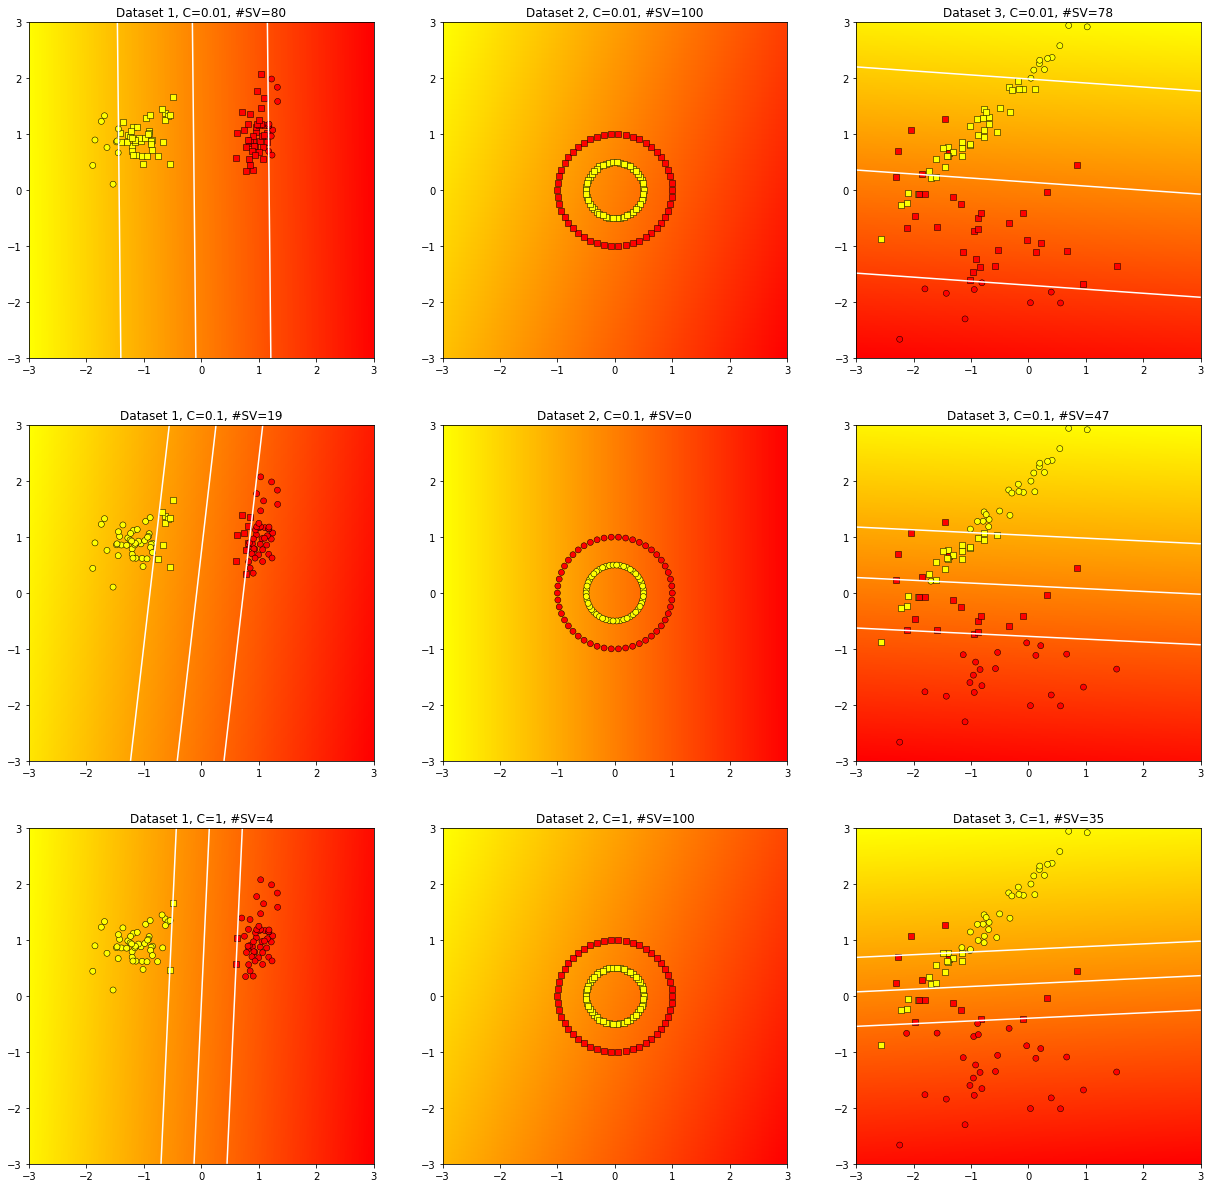

In [ ]:
C_values = [0.01, 0.1, 1]

plot_i = 0
plt.figure(figsize=(len(X) * 7, len(C_values) * 7))
for C in C_values:
    for i in range(len(X)):
        plot_i += 1
        plt.subplot(len(C_values), len(X), plot_i)
        #----------------------------------------------------------------------------
        model = LinearSVM(C=C)
        #----------------------------------------------------------------------------
        model.fit(X[i], y[i])
        sv = model.support_vectors
        n_sv = sv.sum()
        if n_sv > 0:
            plt.scatter(X[i][:, 0][sv], X[i][:, 1][sv], c=y[i][sv], cmap='autumn', marker='s',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        if n_sv < len(X[i]):
            plt.scatter(X[i][:, 0][~sv], X[i][:, 1][~sv], c=y[i][~sv], cmap='autumn',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        xvals = np.linspace(-3, 3, 200)
        yvals = np.linspace(-3, 3, 200)
        xx, yy = np.meshgrid(xvals, yvals)
        zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
        plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
        plt.contour(xx, yy, zz, levels=(-1, 0, 1,), colors='w', linewidths=1.5, zorder=1, linestyles='solid')

        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        plt.title('Dataset {}, C={}, #SV={}'.format(i + 1, C, n_sv))
plt.show()

For debug purposes. Very last model must have almost the same weights and bias:
$$w = \begin{pmatrix}-0.0784521\\ 1.62264867\end{pmatrix}$$
$$b = -0.3528510092782581$$

In [ ]:
model.weights_

array([-0.0784521 ,  1.62264867])

In [ ]:
model.bias_

-0.35285100927825835

Even using a linear SVM, we are able to separate data that is linearly inseparable by using feature transformation.

Implementing the following feature transformation
$
    \phi(x_1, x_2) = (x_1,\ x_2,\ x_1^2,\ x_2^2,\ x_1x_2)
$

In [ ]:
def append_second_order(X):
    """Given array Nx[x1, x2] return Nx[x1, x2, x1^2, x2^2, x1x2]."""
    #------------------------------------------------------------------------------------------
    # return new_X
    x1 = X[:,0:1]
    x2 = X[:,1:]
    X = np.array(np.bmat([x1,x2, np.multiply(x1,x1).reshape(X.shape[0],1), np.multiply(x2,x2).reshape(X.shape[0],1), np.multiply(x1,x2).reshape(X.shape[0],1)]))
    return X
    #------------------------------------------------------------------------------------------

assert np.all(append_second_order(np.array([[1, 2]])) == np.array([[1, 2, 1, 4, 2]])), 'Transformation is incorrect.'

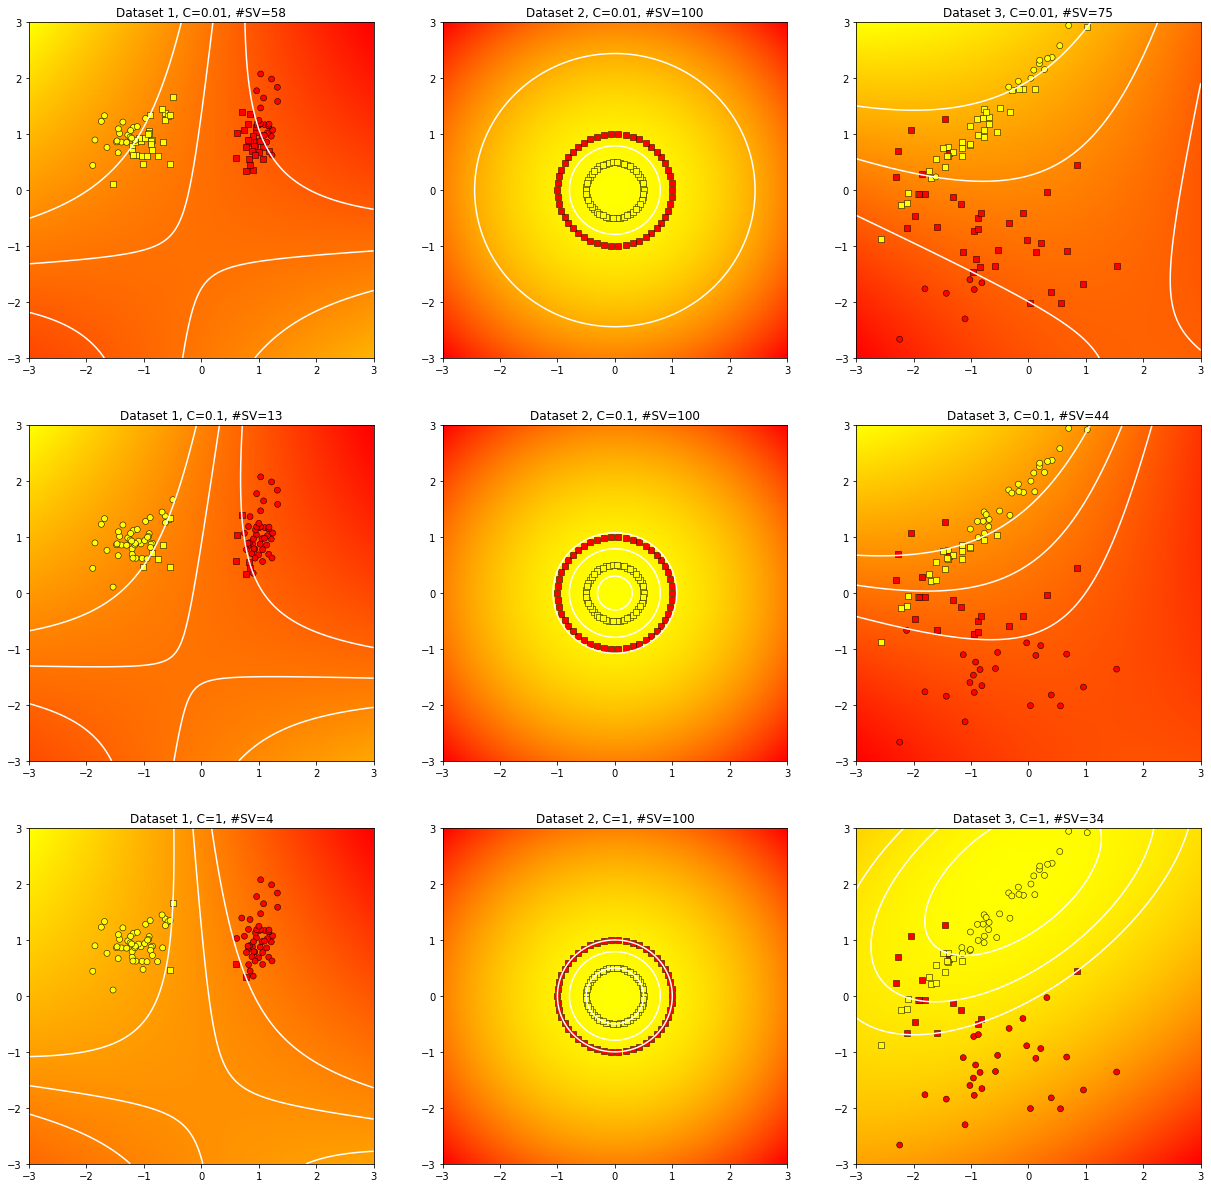

In [ ]:
plot_i = 0
C_values = [0.01, 0.1, 1]
plt.figure(figsize=(len(X) * 7, len(C_values) * 7))
for C in C_values:
    for i in range(len(X)):
        plot_i += 1
        plt.subplot(len(C_values), len(X), plot_i)
        #----------------------------------------------------------------------------
        model = LinearSVM(C=C, transform=append_second_order)
        #----------------------------------------------------------------------------
        model.fit(X[i], y[i])
        sv = model.support_vectors
        n_sv = sv.sum()
        if n_sv > 0:
            plt.scatter(X[i][:, 0][sv], X[i][:, 1][sv], c=y[i][sv], cmap='autumn', marker='s',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        if n_sv < len(X[i]):
            plt.scatter(X[i][:, 0][~sv], X[i][:, 1][~sv], c=y[i][~sv], cmap='autumn',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        xvals = np.linspace(-3, 3, 200)
        yvals = np.linspace(-3, 3, 200)
        xx, yy = np.meshgrid(xvals, yvals)
        zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
        plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
        plt.contour(xx, yy, zz, levels=(-1, 0, 1,), colors='w', linewidths=1.5, zorder=1, linestyles='solid')

        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        plt.title('Dataset {}, C={}, #SV={}'.format(i + 1, C, n_sv))
plt.show()